In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# from pyts.image import GramianAngularField
from pyts.image import GramianAngularField, MarkovTransitionField
from tqdm import tqdm
from PIL import Image

In [2]:
def standardize(df):
    df_standardize = ((df - df.mean()) / df.std())
    return df_standardize

def normalize(df):
    df_normalize = ((df - df.min()) / (df.max() - df.min()))
    return df_normalize


def normalize_global(df, min_val, max_val):
    df_normalize = ((df - min_val) / (max_val - min_val))
    return df_normalize



In [3]:
# find global min and max
files = [file for file in range(1,89+1)]
global_min = float('inf')
global_max = float('-inf')

for img_num in tqdm(files):
    data_path = f"../data/testlog{img_num}.csv"
    df = pd.read_csv(data_path, header=0)


    region = (df["Step_Count"] == 6)
    min = region.idxmax()
    max = region[::-1].idxmax()

    data = (df["RF1_RefPwr"][min:max].fillna(0) + df["RF2_RefPwr"][min:max].fillna(0) + df["RF3_RefPwr"][min:max].fillna(0))/3
    data_min = np.min(data)
    data_max = np.max(data)

    if data_min < global_min:
        global_min = data_min

    if data_max > global_max:
        global_max = data_max



100%|██████████| 89/89 [00:04<00:00, 19.61it/s]


In [4]:
global_max, global_min

(np.float64(147.33333333333334), np.float64(0.0))

In [7]:
df.columns

Index(['Step_Count', 'Press_Set', 'Press_Value', 'Press_Position', 'Top_Temp',
       'Bottom_Temp', 'RF1_FwdPwr', 'RF1_RefPwr', 'RF2_FwdPwr', 'RF2_RefPwr',
       'RF3_FwdPwr', 'RF3_RefPwr', 'RF1_Vpp', 'RF1_Imag', 'RF1_Phase',
       'RF1_ESC_Vrms', 'RF2_Vpp', 'RF2_Imag', 'RF2_Phase', 'RF2_ESC_Vrms',
       'RF3_Vpp', 'RF3_Imag', 'RF3_Phase', 'RF3_ESC_Vrms', 'RF1_Cap1Pos',
       'RF1_Cap2Pos', 'RF2_Cap1Pos', 'RF2_Cap2Pos', 'RF3_Cap1Pos',
       'RF3_Cap2Pos', 'Wall_SetTemp', 'Wall_Temp', 'Wall_Output',
       'GDP_SetTemp', 'GDP_Temp', 'GDP_Output', 'Liner1_SetTemp',
       'Liner1_Temp', 'Liner1_Output', 'BC1_SetPress', 'BC1_Press', 'BC1_Flow',
       'BC1_LeakFlow', 'BC2_SetPress', 'BC2_Press', 'BC2_Flow', 'BC2_LeakFlow',
       'Chiller1_SetTemp', 'Chiller1_Temp', 'Chiller1_Press',
       'Chiller1_FlowRate', 'Chiller2_SetTemp', 'Chiller2_Temp',
       'Chiller2_Press', 'Chiller2_FlowRate', 'Valve_Position', 'eESC_Volt',
       'eESC_PosOut', 'EB_Cap', 'EB_Volt', 'EB_Current', 'EB

# Perform on all

In [13]:
def save_combined_image_as_img(gaf_image, mtf_image, file_path):
    # Stack GAF and MTF images along the channel dimension
    combined_image = np.stack([gaf_image, mtf_image], axis=2)
    
    # Convert to uint8 format (if necessary)
    combined_image = (combined_image * 255).astype(np.uint8)
    
    # Convert numpy array to Image
    combined_image_pil = Image.fromarray(combined_image)
    
    # Save the image
    combined_image_pil.save(file_path)

In [5]:
def save_combined_image_as_np(gaf_image, mtf_image, file_path):
    # Stack GAF and MTF images along the channel dimension
    combined_image = np.stack([gaf_image, mtf_image], axis=2).astype(np.float32)
    
    # Convert to uint8 format (if necessary)
    # combined_image = (combined_image * 255).astype(np.uint8)
    
    # Convert numpy array to Image
    # combined_image_pil = Image.fromarray(combined_image)
    
    # Save the image
    np.save(file_path,combined_image)

In [7]:
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")
image_size = 400
gsaf = GramianAngularField(image_size=image_size, method="summation")
mtf = MarkovTransitionField(image_size=image_size, n_bins=5)

files = [file for file in range(1,89+1)]

for img_num in tqdm(files):
    data_path = f"../data/testlog{img_num}.csv"
    df = pd.read_csv(data_path, header=0)


    region = (df["Step_Count"] == 6)
    min = region.idxmax()
    max = region[::-1].idxmax()

    data = (df["RF1_RefPwr"][min:max].fillna(0) + df["RF2_RefPwr"][min:max].fillna(0) + df["RF3_RefPwr"][min:max].fillna(0))/3
    # data_min = np.min(data_norm)
    # if (np.max(data_norm) == 0):
    #     data_max = 1
    # else:
    #     data_max = np.max(data_norm)

    data_array = np.array(data)
    segment_size = 400
    num_segments = len(data_array) // segment_size
    remainder = len(data_array) - num_segments * segment_size
    # remove some portion of data to fit into nice length segments
    segments = np.array_split(data_array[remainder:], num_segments)
    for i, segment in enumerate(segments):
        data = normalize_global(segment, global_min, global_max)
        # data = data.reshape((1,-1))
        # values = np.array([0, 1])

        # data = np.concatenate((values, data))


        # gaf_image = gsaf.transform(data)[0]
        # gaf_image = normalize_global(gsaf.transform(data), data_min, data_max)[0]
        # mtf_image = gaf_image # mtf works terribly on images of nearly empty data
        # mtf_image = normalize_global(mtf.transform(data), data_min, data_max)[0]

        file_path = f"../gaf_data/train/0/img{img_num}_{i}"
        # save_combined_image_as_np(gaf_image, mtf_image, file_path)
        np.savez_compressed(file_path, data=data)

100%|██████████| 89/89 [00:04<00:00, 18.06it/s]


## visualize output

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# from pyts.image import GramianAngularField
from pyts.image import GramianAngularField, MarkovTransitionField
from tqdm import tqdm
from PIL import Image

In [8]:
data1 = np.load('../gaf_data/vpp/train/0/img7_21.npz')['data']
data2 = np.load('../gaf_data/vpp/train/0/img22_30.npz')['data']

values = np.array([0, 1])

# Add the values to the front
data1 = np.concatenate((values, data1))
data2 = np.concatenate((values, data2))

# data_norm = normalize_global(data, global_min, global_max)
# data = data_norm.fillna(0).to_numpy().reshape((1,-1))
data1 = data1.reshape((1,-1))
data2 = data2.reshape((1,-1))
image_size = 400
gsaf = GramianAngularField(image_size=image_size, 
                           method="summation",
						   sample_range=(0,1))
# mtf = MarkovTransitionField(image_size=image_size, n_bins=5)
gaf_image1 = gsaf.transform(data1)[0]
gaf_image2 = gsaf.transform(data2)[0]
# gaf_image = normalize(gsaf.transform(data))[0]
# mtf_image = normalize(mtf.transform(data))[0]

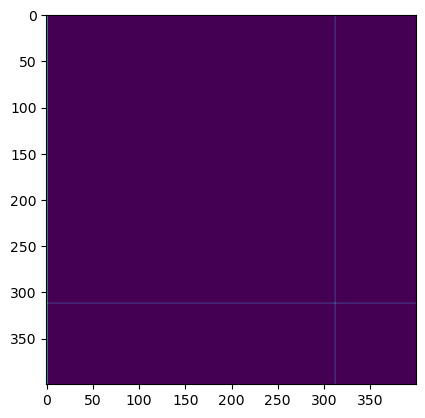

In [9]:
plt.imshow(gaf_image1)

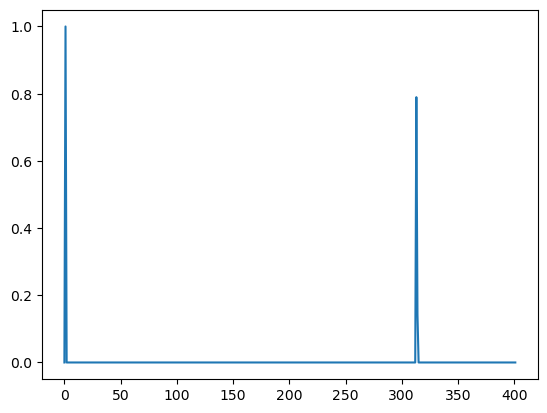

In [10]:
plt.plot(data1.reshape((-1,1)))

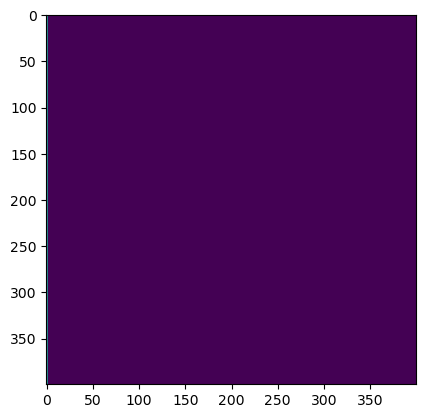

In [11]:
plt.imshow(gaf_image2)

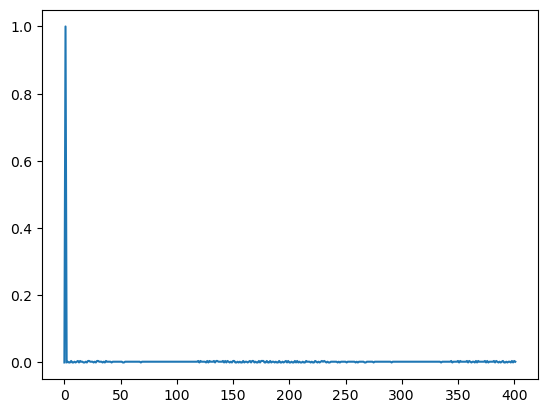

In [12]:
plt.plot(data2.reshape((-1,1)))

In [13]:
gaf_image1[310:320, 310:320]


array([[-1.        , -1.        , -0.61363122, -0.98978992, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -0.61363122, -0.98978992, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ],
       [-0.61363122, -0.61363122,  0.24691345, -0.49482223, -0.61363122,
        -0.61363122, -0.61363122, -0.61363122, -0.61363122, -0.61363122],
       [-0.98978992, -0.98978992, -0.49482223, -0.95936815, -0.98978992,
        -0.98978992, -0.98978992, -0.98978992, -0.98978992, -0.98978992],
       [-1.        , -1.        , -0.61363122, -0.98978992, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -0.61363122, -0.98978992, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -0.61363122, -0.98978992, -1.        ,
        -1.        , -1.        , -1.        

In [14]:
gaf_image2[0:10, 0:10]

array([[-1.        ,  0.        , -1.        , -0.99999744, -1.        ,
        -1.        , -0.99998976, -1.        , -1.        , -0.99999744],
       [ 0.        ,  1.        ,  0.        ,  0.00226244,  0.        ,
         0.        ,  0.00452489,  0.        ,  0.        ,  0.00226244],
       [-1.        ,  0.        , -1.        , -0.99999744, -1.        ,
        -1.        , -0.99998976, -1.        , -1.        , -0.99999744],
       [-0.99999744,  0.00226244, -0.99999744, -0.99998976, -0.99999744,
        -0.99999744, -0.99997697, -0.99999744, -0.99999744, -0.99998976],
       [-1.        ,  0.        , -1.        , -0.99999744, -1.        ,
        -1.        , -0.99998976, -1.        , -1.        , -0.99999744],
       [-1.        ,  0.        , -1.        , -0.99999744, -1.        ,
        -1.        , -0.99998976, -1.        , -1.        , -0.99999744],
       [-0.99998976,  0.00452489, -0.99998976, -0.99997697, -0.99998976,
        -0.99998976, -0.99995905, -0.99998976